**import**

In [1]:
from path_finder import GreedySearch
from path_finder import BFS
from path_finder import DFS
from path_finder import AStarSearch
from graph_generator import read_input_file
from matplotlib import pyplot as plt
import time
from IPython.display import display

%matplotlib inline

**test function**

In [2]:
import timeit
def test(algorithm, start, goal, matrix, is_print=True):
    path_finder = algorithm(start, goal)
    
    start_tick = timeit.default_timer()
    path = path_finder.search(matrix)
    end_tick = timeit.default_timer()
    
    fig = plt.figure()
    fig.canvas.draw()
    PATH_VALUE = 9
    
    if path:
        print("Found path")
        for pos in path:
            matrix[pos] = PATH_VALUE
    else:
        print("Not found path")
    
    if is_print:
        print(f'distance: {len(path)}, time: {end_tick - start_tick}')
        matrix[start] = PATH_VALUE + 2
        matrix[goal] = PATH_VALUE + 2
        fig.canvas.draw()
        plt.imshow(matrix, cmap="tab20c")
        plt.show()

**main**

BFS
Found path
distance: 32, time: 0.03560484400077257


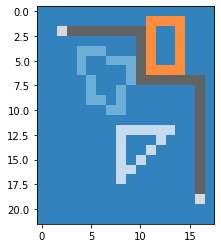

DFS
Found path
distance: 90, time: 0.024347292999664205


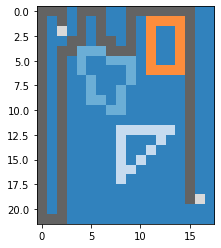

A
Found path
distance: 32, time: 0.007699531000980642


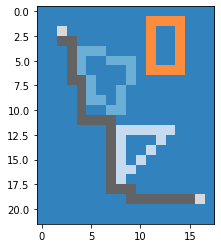

A*
Found path
distance: 32, time: 0.01851919200089469


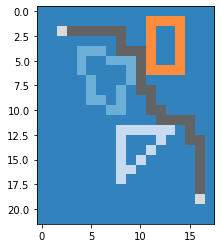

In [69]:
# from path_finder import BFS
# from graph_generator import read_input_file

def read_input_and_test(algorithm):
    input_path = 'sample_input.txt'
    matrix, start, goal = read_input_file(input_path)
    if algorithm != None:
        test(algorithm, start, goal, matrix)

if __name__ == '__main__':
#     input_path = 'sample_input.txt'
#     matrix, start, goal = read_input_file(input_path)
    print('BFS')
    read_input_and_test(BFS)
    print('DFS')
    read_input_and_test(DFS)
    print('A')
    read_input_and_test(GreedySearch)
    print('A*')
    read_input_and_test(AStarSearch)

## Collecting all points before reaching the goal

In [153]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

In [276]:
import heapq
import numpy as np
import random
from path_finder import BasePathFinder
from path_finder import BFS
import json

REACHED_POINT_FLAG = 88

class AllPointSearch():
    def __init__(self, start, goal, list_point, list_move=[(0, 1), (0, -1), (1, 0), (-1, 0)]):
        self.list_point = list_point
        self.start = start
        self.goal = goal
        self.list_move = list_move
        self.list_point = list_point

        ## this att is used for find path between two points:
        ## path_lookup[start][goal] = ['A', 'B', 'C', ...]
        self.path_lookup = {}
        self.visited = np.zeros((len(list_point), len(list_point)))
#         self.edges = []
#         self._init_edges()
    
    def _find_shortest_path(self, start_point, end_point, matrix):
        shortest_path_finder = BFS(start_point, end_point)
        return shortest_path_finder.search(matrix)
    
    def _init_path_lookup(self, matrix):
        matrix[goal] += 1
        for i, start_point in enumerate(list_point):
            shortest_path = self._find_shortest_path(self.start, start_point, matrix)
            self._update_path_lookup(self.start, start_point, shortest_path)
            
            for j in range(i+1, len(list_point)):
                end_point = list_point[j]
                if j == i or self.visited[i, j] == 1 or self.visited[j, i] == 1:
                    continue
                
                shortest_path = self._find_shortest_path(start_point, end_point, matrix)
                self._update_path_lookup(start_point, end_point, shortest_path)
                
                reverse_shortest_path = shortest_path.copy()
                if shortest_path != False:
                    reverse_shortest_path.reverse()
                    
                self._update_path_lookup(end_point, start_point, reverse_shortest_path)
                                
                self.visited[i, j] = 1
                self.visited[j, i] = 1
        
        matrix[goal] -= 1
        
    def _update_path_lookup(self, head, tail, path):
        if head not in self.path_lookup:
            self.path_lookup[head] = []
        
        dist = 1e9
        if path != False:
            dist = len(path)
        #heapq.heappush(self.path_lookup[head], (dist, tail, path))
        self.path_lookup[head].append((dist, tail, path))
    
    def _lookup_path_of_point(self, start_point):
        return heapq.heappop(self.path_lookup[start_point])
    
    def show_path_lookup(self):
        print(f'path_lookup type: {type(self.path_lookup)}')
        print(f'path_lookup key: {list(self.path_lookup.keys())}')
        print(f'path_lookup: {self.path_lookup}')
    
    def search(self, matrix):
        self._init_path_lookup(matrix)
        #self.show_path_lookup()
        #pretty(self.path_lookup, indent=2)
        
        final_path = [] # list of points that leads to goal
        reaching_order = [] # order of points we will reach - dtype: list of points
        total_distance = 0
        
        start_point = self.start
        num_of_list_point = len(list_point)
        
        while num_of_list_point > 0:
            distance, next_point, path = self._lookup_path_of_point(start_point)
            
            if matrix[next_point] != REACHED_POINT_FLAG:
                total_distance += distance
                final_path += path
                reaching_order+= [next_point]
                
                matrix[next_point] = REACHED_POINT_FLAG
                start_point = next_point
                num_of_list_point-=1

        
        ## find shortest path from the final point to goal
        shortest_path_to_goal = self._find_shortest_path(reaching_order[-1], goal, matrix)

        total_distance += len(shortest_path_to_goal)
        reaching_order.append(goal)
        final_path.extend(shortest_path_to_goal)
        
        return final_path, reaching_order, total_distance

In [237]:
from graph_generator import GraphGenerator

def read_multi_point_input(fpath:str, verbose:bool=False, fill:bool=False):
    """ Read input file with TA Format
    Input:
        fpath: Path to input txt file
        verbose: Print to screen to debug
        fill: Should we fill the polygon
    Output:
        graph: (Numpy array) Matrix to represent graph value
        start: (Tuple of int) Start point
        goal: (Tuple of int) Goal point
    """
    f = open(fpath)
    l = f.readline()
    w, h = [int(x) for x in l.strip().split(',')]

    if verbose:
        print("Read from file....")
        print(f"Width={w}, Height={h}")

    generator = GraphGenerator((h, w), fill=fill)
    
    l = f.readline()
    
    #xStart, yStart, xGoal, yGoal = [int(x) for x in l.strip().split(',')]
    list_coor = l.strip().split(',')
    list_x = list_coor[1::2]
    list_y = list_coor[::2]
    list_x = [int(x) for x in list_x]
    list_y = [int(y) for y in list_y]

    xStart, yStart, xGoal, yGoal = list_x[0], list_y[0], list_x[1], list_y[1]
    list_point = [(list_x[i], list_y[i]) for i in range(2, len(list_x))]
    
    
    if verbose:
        print(f"Start: ({xStart}, {yStart})")
        print(f"Goal: ({xGoal}, {yGoal})")

    num_polygon = int(f.readline().strip())

    if verbose:
        print(f"Found {num_polygon} Polygons")
    for pInd in range(num_polygon):
        l = f.readline()
        point_list = [int(x) for x in l.strip().split(',')]
        polygon = list(zip(point_list[::2], point_list[1::2]))

        generator.add_polygon(polygon)

    f.close()

    if verbose:
        print("Done load input")
        generator.plot_graph()

    return generator.generate_graph(), (xStart, yStart), (xGoal, yGoal), list_point


## main

In [277]:
file_path = "multi_points.txt"
#file_path = "sample_input.txt"
matrix, start, goal, list_point = read_multi_point_input(file_path)
#matrix, start, goal = read_input_file(file_path)

In [278]:
print(list_point)
print(start)
print(goal)

[(5, 1), (2, 8), (9, 8), (19, 3), (2, 20)]
(1, 1)
(19, 20)


In [279]:
all_point_finder = AllPointSearch(start, goal, list_point)

In [ ]:
final_path, reaching_order, total_distance = all_point_finder.search(matrix)

Found path


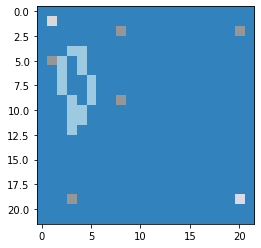

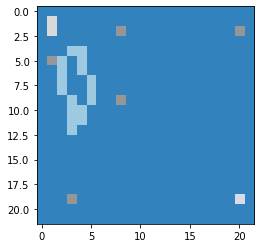

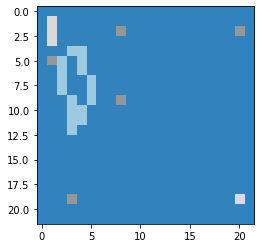

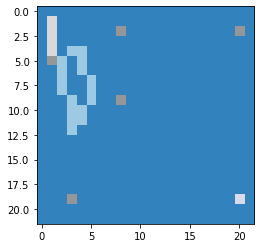

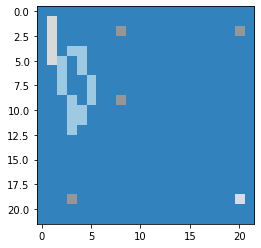

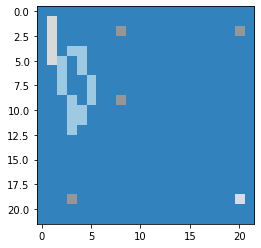

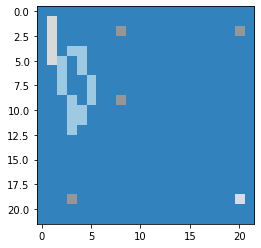

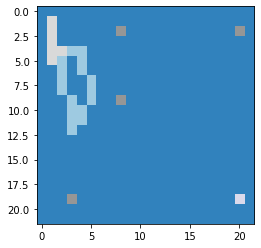

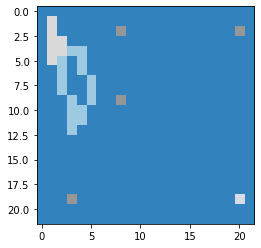

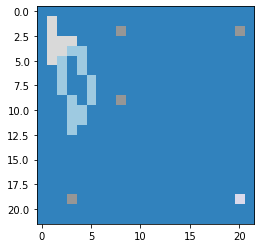

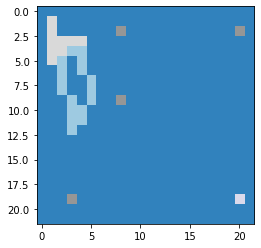

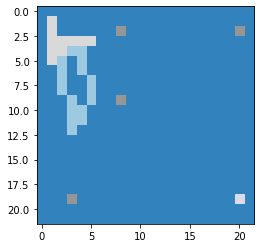

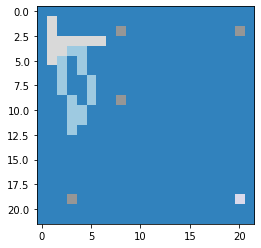

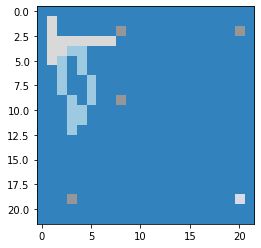

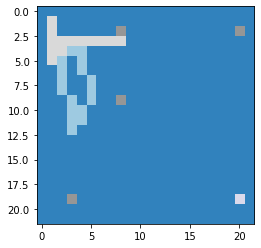

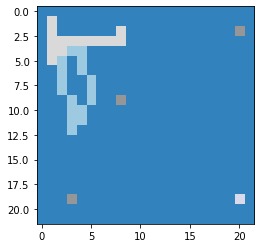

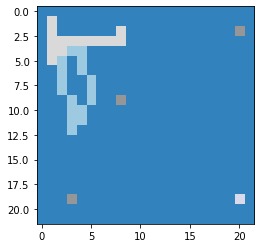

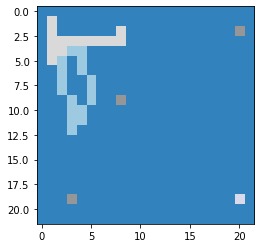

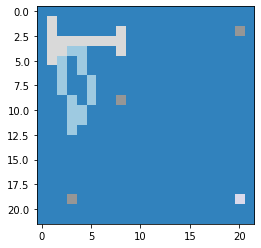

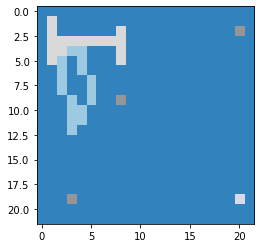

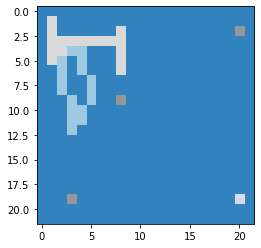

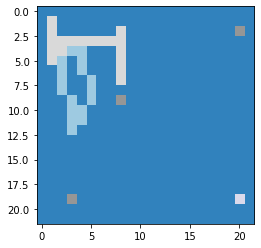

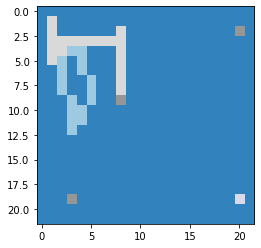

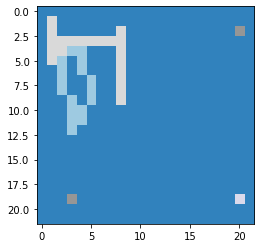

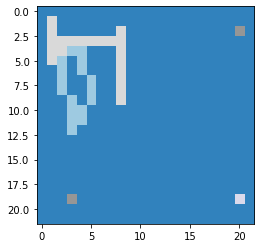

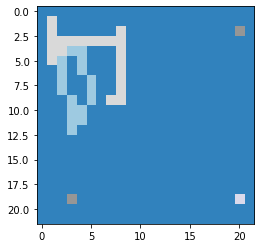

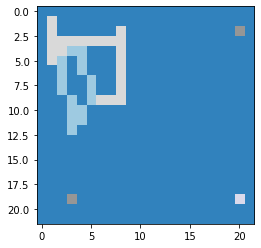

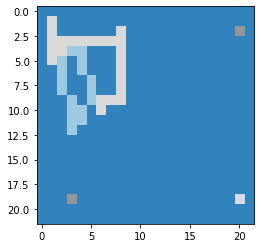

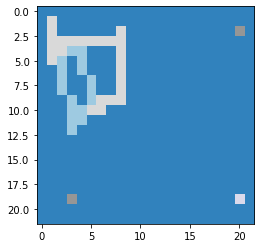

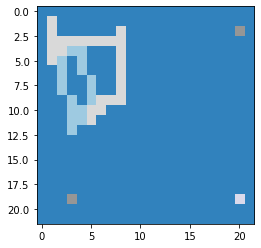

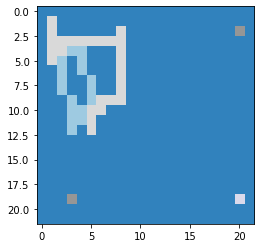

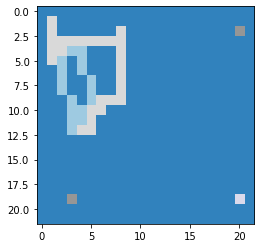

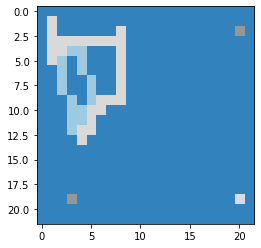

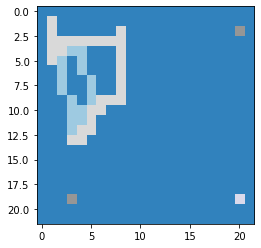

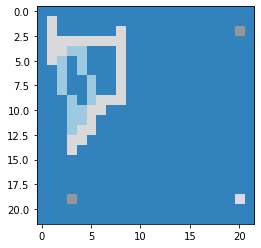

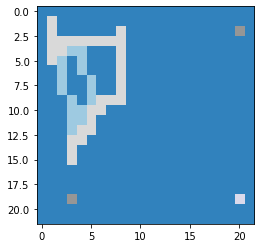

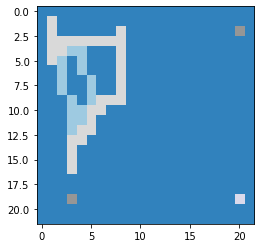

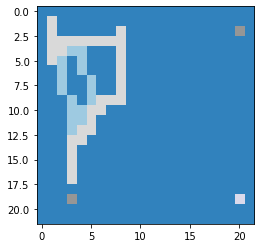

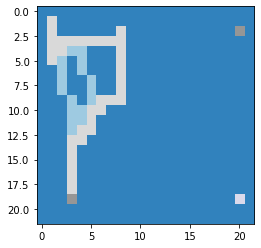

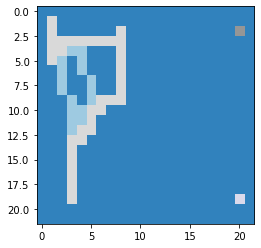

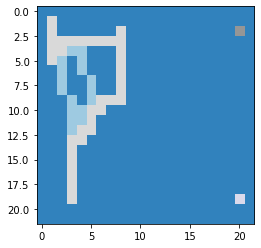

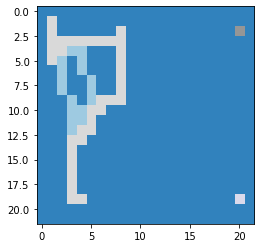

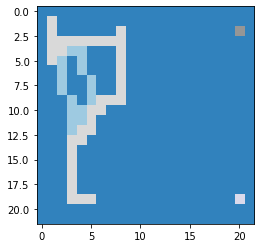

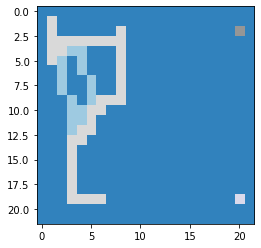

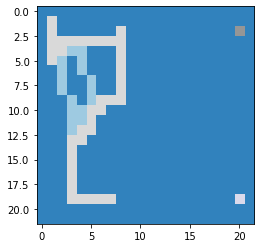

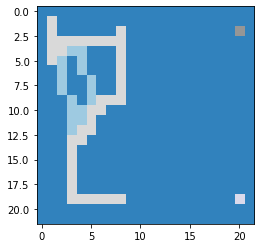

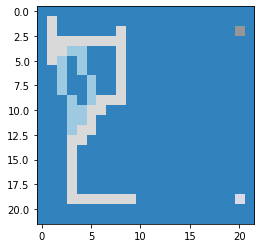

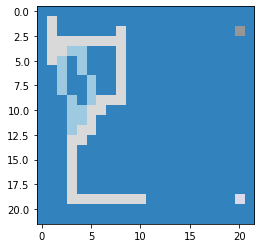

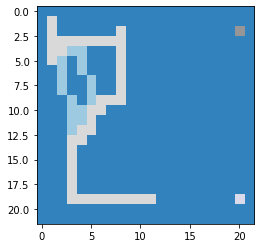

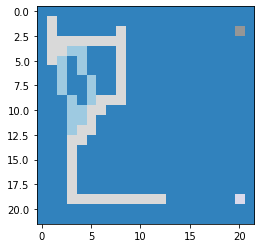

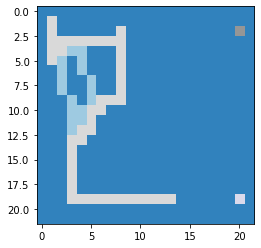

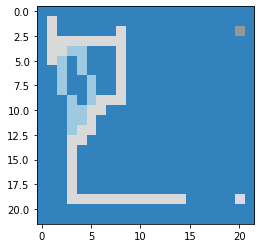

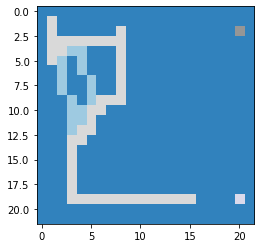

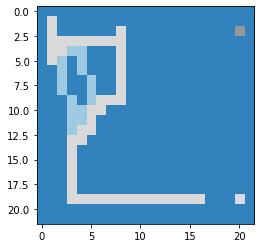

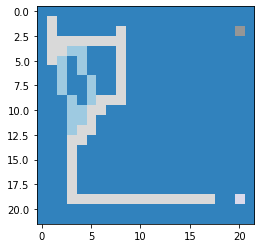

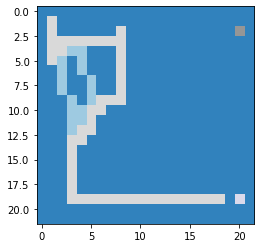

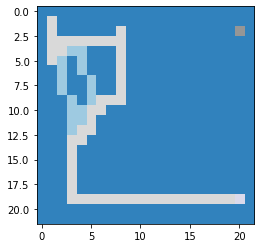

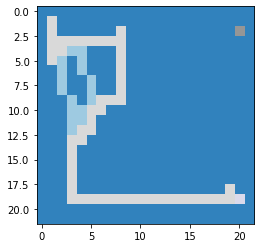

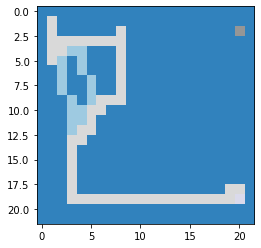

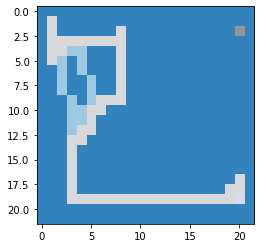

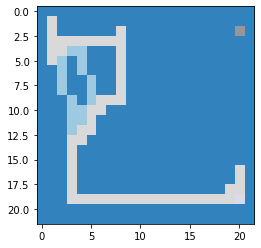

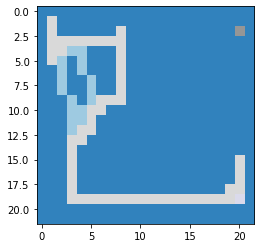

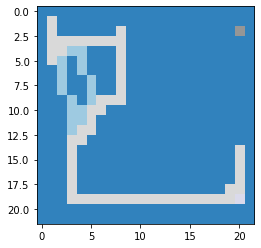

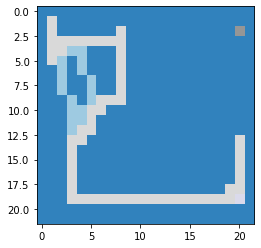

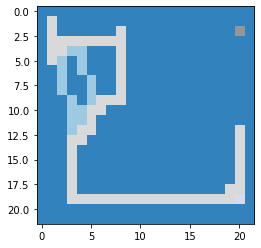

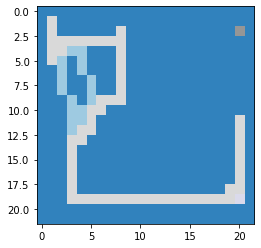

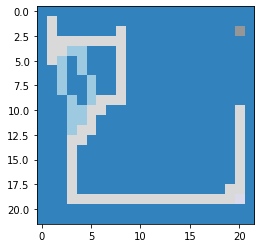

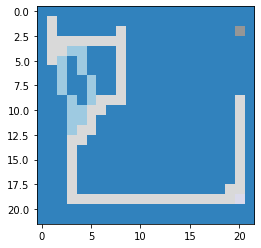

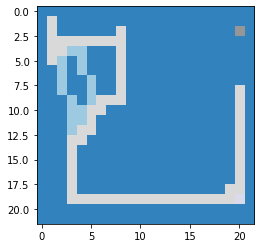

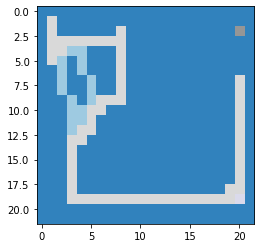

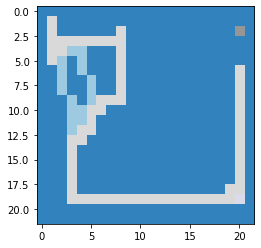

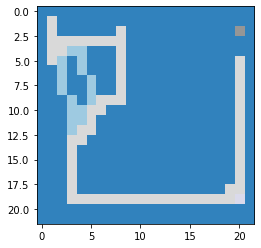

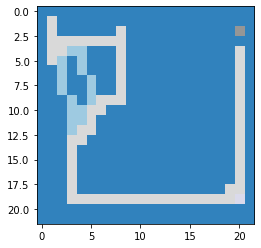

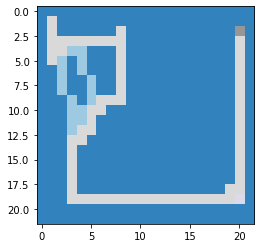

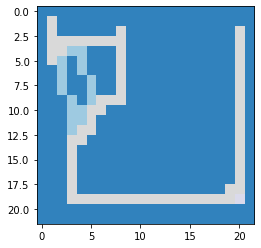

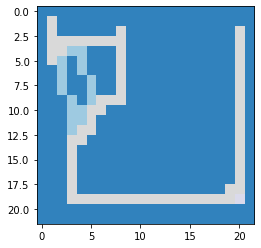

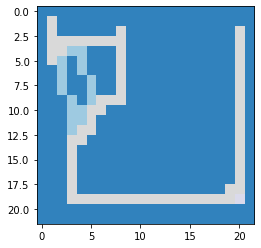

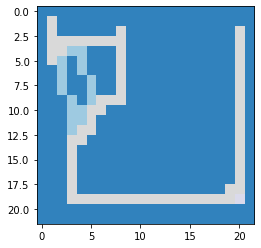

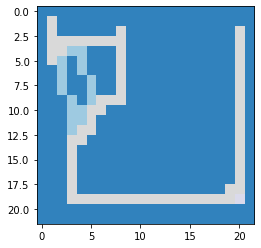

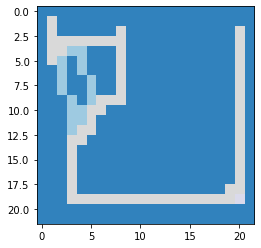

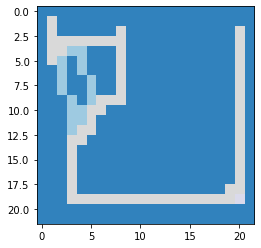

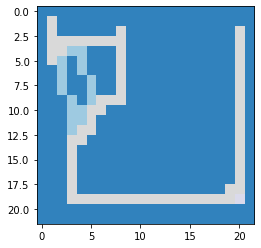

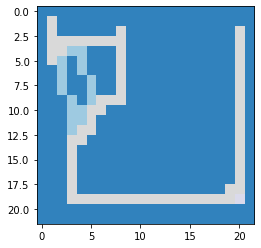

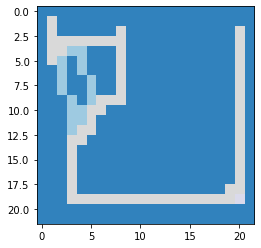

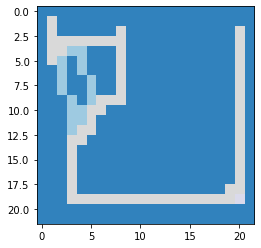

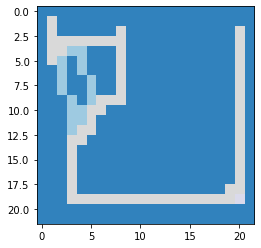

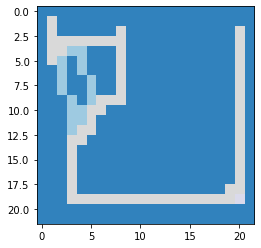

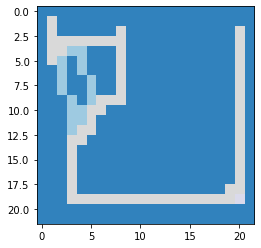

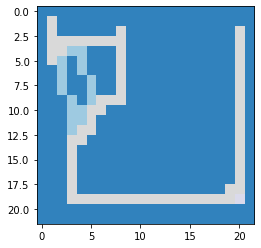

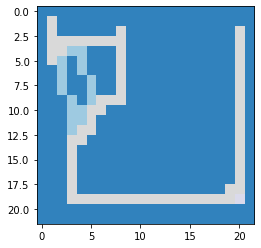

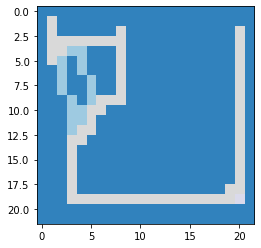

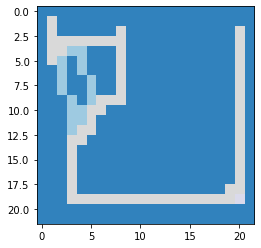

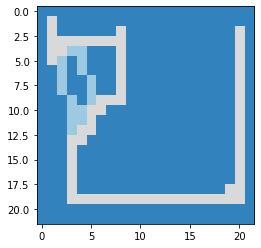

In [281]:
fig = plt.figure()
fig.canvas.draw()
PATH_VALUE = 9

matrix[start] = 7
matrix[goal] = 7
for p in list_point:
    matrix[p] = 8
    
if final_path:
    print("Found path")
    for pos in final_path:
        if matrix[pos] != PATH_VALUE:
            matrix[pos] = PATH_VALUE
        plt.imshow(matrix, cmap="tab20c")
        plt.show()
else:
    print("Not found path")
    

In [282]:
reaching_order

[(5, 1), (2, 8), (9, 8), (19, 3), (2, 20), (19, 20)]

In [283]:
total_distance

93